# Research Question 2, GLM + Nonparametric Methods

## Can mobility metrics for each US County adequately predict the number of COVID-19 cases a given county had over an established time span?

In [ ]:
!pip install -r 'requirements.txt'

  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.7
    Not uninstalling decorator at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'decorator'. No files were found to uninstall.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import ExcelWriter
from pandas import ExcelFile
import missingno as msno
import datetime

In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
import pymc3 as pm
from pymc3 import glm
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.tools.eval_measures import rmse
import arviz

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Preprocessing

In the following 3 cells, basic data cleaning and processing transformations are applied.

We have four datasets that require processing before they can be merged. 
 - The **region_2020 and region_df2021** dataframe contains mobility metrics for every county in the USA from 2020 to 2021
 - The **cases_by_county** dataframe contains the number of cases and deaths for every county in the USA.
 - The **countypop_2019** contains population estimates for every county in the USA, circa 2019

**region_2020 and region_2020** was modified and transformed in the following ways:
- sub_region1, sub_region2 renamed to county and state respectively for clarity
- date transformed into a datetime
- metro_area, country_region_code, iso_3166_2_code, census_fips, place_id, country_region were all dropped due to lack of relevance to problem statement
- state, county combinations that were of type nan values were dropped (**note that this does not mean that a (state, county) was dropped if a (state, county) contained nan values for any mobility metric**)
- String manipulations performed upon county to retreive the county name without the suffix "county"

In [ ]:

region2020_df = pd.read_csv('2020_US_Region_Mobility_Report.csv')
region2020_df = region2020_df.rename({'sub_region_1': 'state', 'sub_region_2': 'county'}, axis=1)
region2020_df = region2020_df.drop(columns = ['metro_area', 'country_region_code', 'iso_3166_2_code', 'census_fips_code', 'place_id','country_region'])
region2020_df = region2020_df.dropna(subset=["state","county"])
region2020_df['county'] = region2020_df['county'].astype(str)
region2020_df['county'] = region2020_df['county'].str.extract(r'([a-zA-Z]+)')
region2020_df['date'] = pd.to_datetime(region2020_df['date'],format='%Y-%m-%d')
region2020_df = region2020_df[region2020_df['date'] >= '2020-03-01']
region2020_df

,state,county,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
657,Alabama,Autauga,2020-03-01,15.0,13.0,NaN,NaN,3.0,NaN
658,Alabama,Autauga,2020-03-02,15.0,4.0,NaN,NaN,5.0,-1.0
659,Alabama,Autauga,2020-03-03,22.0,8.0,NaN,NaN,4.0,-1.0
660,Alabama,Autauga,2020-03-04,5.0,-4.0,NaN,NaN,3.0,2.0
661,Alabama,Autauga,2020-03-05,7.0,12.0,NaN,NaN,3.0,1.0
...,...,...,...,...,...,...,...,...,...
812060,Wyoming,Weston,2020-12-24,NaN,NaN,NaN,NaN,-56.0,NaN
812061,Wyoming,Weston,2020-12-28,NaN,NaN,NaN,NaN,-40.0,NaN
812062,Wyoming,Weston,2020-12-29,NaN,NaN,NaN,NaN,-43.0,NaN
812063,Wyoming,Weston,2020-12-30,NaN,NaN,NaN,NaN,-40.0,NaN


In [ ]:

region2021_df = pd.read_csv('2021_US_Region_Mobility_Report.csv')
region2021_df
region2021_df = region2021_df.rename({'sub_region_1': 'state', 'sub_region_2': 'county'}, axis=1)
region2021_df = region2021_df.drop(columns = ['metro_area', 'country_region_code', 'iso_3166_2_code', 'census_fips_code', 'place_id','country_region'])
region2021_df = region2021_df.dropna(subset=["state","county"])
region2021_df['county'] = region2021_df['county'].astype(str)
region2021_df['county'] = region2021_df['county'].str.extract(r'([a-zA-Z]+)')
region2021_df['date'] = pd.to_datetime(region2021_df['date'],format='%Y-%m-%d')
region2021_df = region2021_df[region2021_df['date'] <= '2021-01-01']
region2021_df


,state,county,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
246,Alabama,Autauga,2021-01-01,-46.0,-28.0,NaN,NaN,-77.0,28.0
369,Alabama,Baldwin,2021-01-01,-34.0,-27.0,24.0,-45.0,-70.0,21.0
492,Alabama,Barbour,2021-01-01,-42.0,NaN,NaN,NaN,-69.0,NaN
615,Alabama,Bibb,2021-01-01,NaN,NaN,NaN,NaN,-72.0,NaN
738,Alabama,Blount,2021-01-01,-45.0,-28.0,NaN,NaN,-75.0,28.0
...,...,...,...,...,...,...,...,...,...
319704,Wyoming,Sweetwater,2021-01-01,-42.0,NaN,NaN,12.0,-66.0,22.0
319827,Wyoming,Teton,2021-01-01,-46.0,-38.0,13.0,-37.0,-53.0,NaN
319950,Wyoming,Uinta,2021-01-01,-28.0,NaN,NaN,22.0,-63.0,19.0
320073,Wyoming,Washakie,2021-01-01,NaN,NaN,NaN,NaN,-68.0,NaN


In [ ]:
region_df = pd.concat([region2020_df, region2021_df], ignore_index=True, sort=False)
region_df

,state,county,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Alabama,Autauga,2020-03-01,15.0,13.0,NaN,NaN,3.0,NaN
1,Alabama,Autauga,2020-03-02,15.0,4.0,NaN,NaN,5.0,-1.0
2,Alabama,Autauga,2020-03-03,22.0,8.0,NaN,NaN,4.0,-1.0
3,Alabama,Autauga,2020-03-04,5.0,-4.0,NaN,NaN,3.0,2.0
4,Alabama,Autauga,2020-03-05,7.0,12.0,NaN,NaN,3.0,1.0
...,...,...,...,...,...,...,...,...,...
758285,Wyoming,Sweetwater,2021-01-01,-42.0,NaN,NaN,12.0,-66.0,22.0
758286,Wyoming,Teton,2021-01-01,-46.0,-38.0,13.0,-37.0,-53.0,NaN
758287,Wyoming,Uinta,2021-01-01,-28.0,NaN,NaN,22.0,-63.0,19.0
758288,Wyoming,Washakie,2021-01-01,NaN,NaN,NaN,NaN,-68.0,NaN


**cases_by_county** was modified in the following ways:
 - any rows containing nan values were dropped, later on this DataFrame is inner-joined with the **region_df** meaning that any mismatches are discarded - this only keeps counties with well-maintained covid records


In [ ]:
## Only keep counties with well-kept/maintained records

cases_by_county = pd.read_csv('us-counties.csv')
cases_by_county = cases_by_county.dropna()
cases_by_county['date'] = pd.to_datetime(cases_by_county['date'])
cases_by_county

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0
...,...,...,...,...,...,...
1297018,2021-05-07,Sweetwater,Wyoming,56037.0,4285,38.0
1297019,2021-05-07,Teton,Wyoming,56039.0,3751,9.0
1297020,2021-05-07,Uinta,Wyoming,56041.0,2217,13.0
1297021,2021-05-07,Washakie,Wyoming,56043.0,910,26.0


**countypop_2019** was modified in the following ways:
- Only relevant columns were selected in projection (state name, county name, population estimate 2019)
- Columns renamed to match nomenclature of other DataFrames (STNAME -> state, CTYNAME -> county)
- String manipulation performed on county to keep formatting consistent with other datasets to enable easier merging later


In [ ]:
## Retrieve 2019 populations for each county in California
## Peform string manipulations and splits to retreive county and state as separate columns to enable joins with other dataset

county_pop = pd.read_csv('county_pop.csv', encoding='latin-1')
countypop_2019= county_pop[['STNAME', 'CTYNAME', 'POPESTIMATE2019']]
# countypop_2019 = california_county_pop.iloc[:,[0,12]]
countypop_2019.columns = ['state','county','population']
countypop_2019['county'] = countypop_2019['county'].astype(str)
countypop_2019['county'] = countypop_2019['county'].str.extract(r'([a-zA-Z]+)')
countypop_2019.head(1)

<ipython-input-8-515fc90559a6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countypop_2019['county'] = countypop_2019['county'].astype(str)
<ipython-input-8-515fc90559a6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countypop_2019['county'] = countypop_2019['county'].str.extract(r'([a-zA-Z]+)')


,state,county,population
0,Alabama,Alabama,4903185


### The following cells identify and visualize missing and nan values in the various datasets we have. The package missingno is utilized. 

<AxesSubplot:>

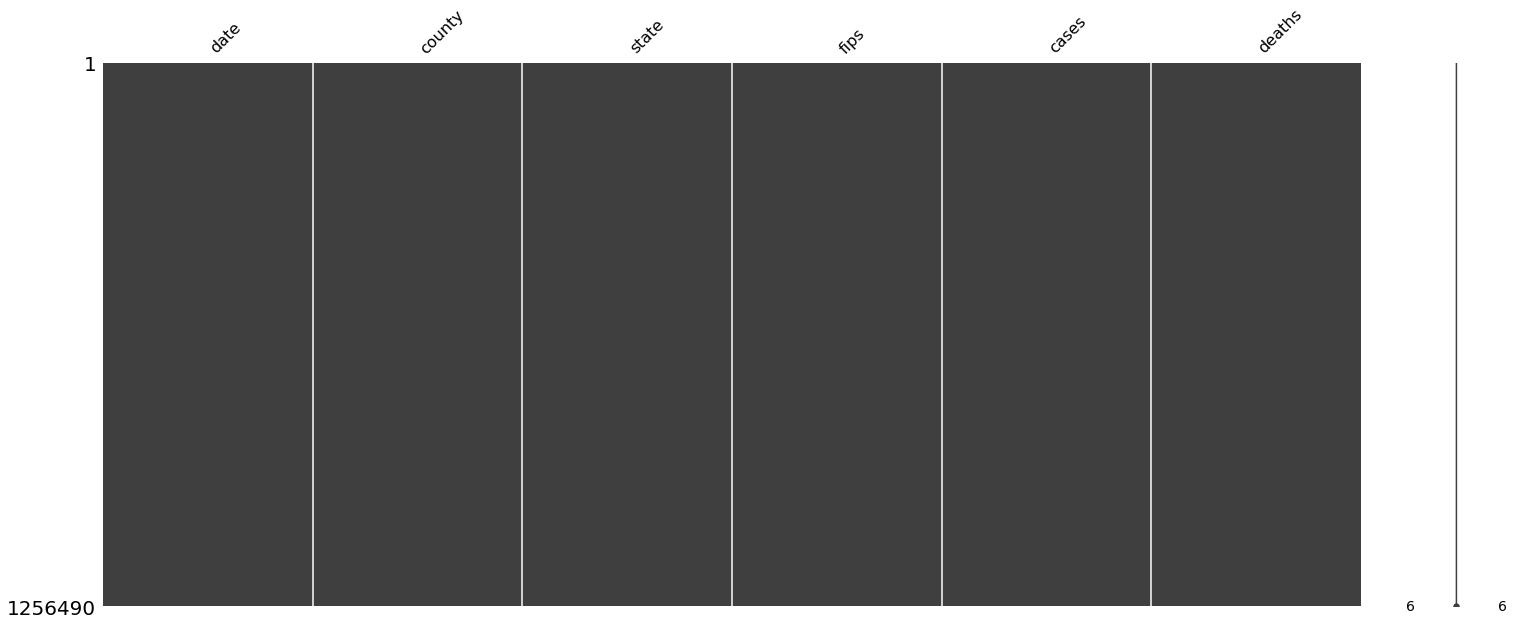

In [ ]:
msno.matrix(cases_by_county)

<AxesSubplot:>

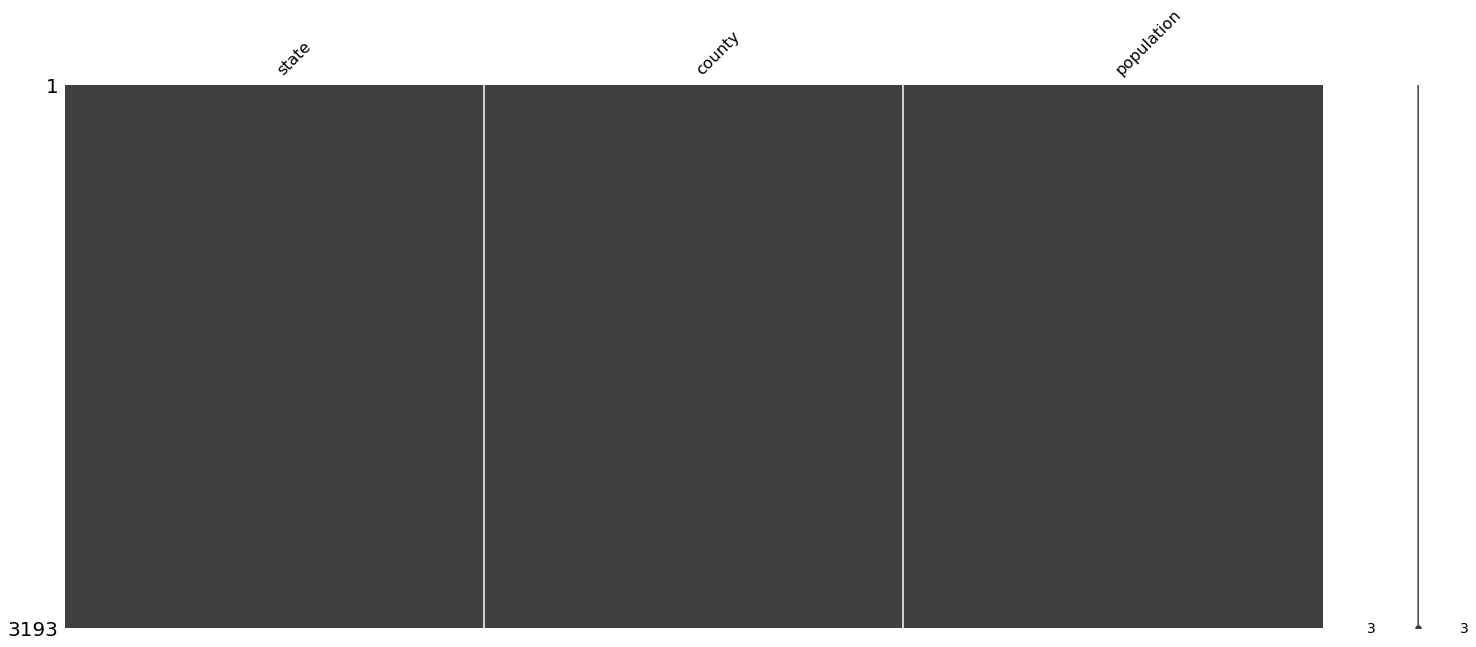

In [ ]:
msno.matrix(countypop_2019)

<AxesSubplot:>

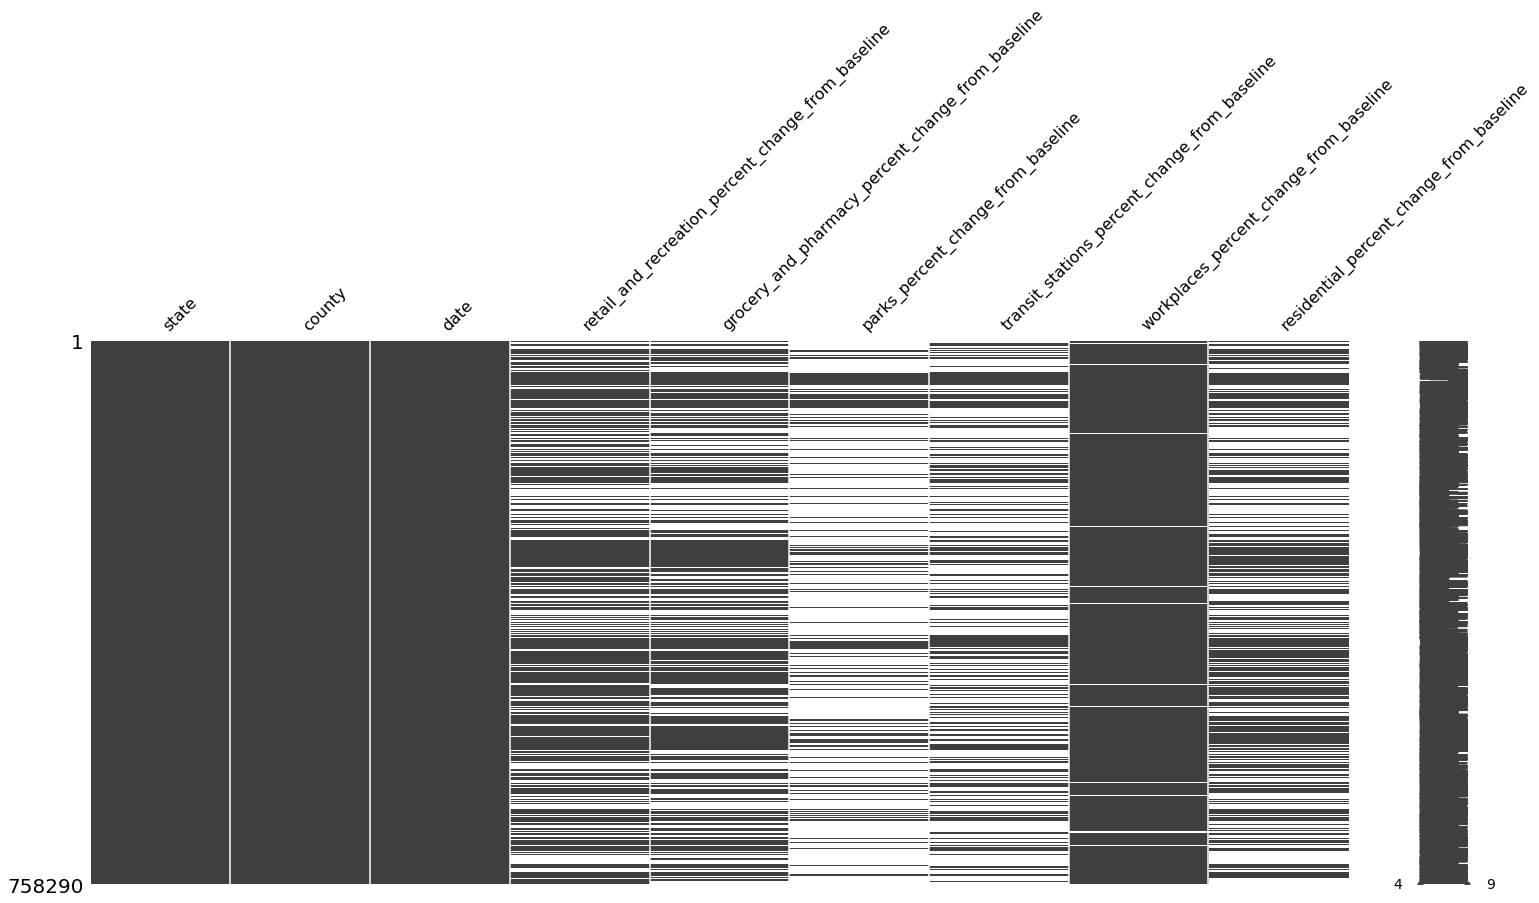

In [ ]:
msno.matrix(region_df)

As we can see, **region_df** contains many nan and missing values for various mobility metrics. Datasets **countypop_2019** and **cases_by_county** are fully complete and contain no missing values. Decisions regarding how to deal with the missing/nan values in the **region_df** will require more EDA. 

<AxesSubplot:>

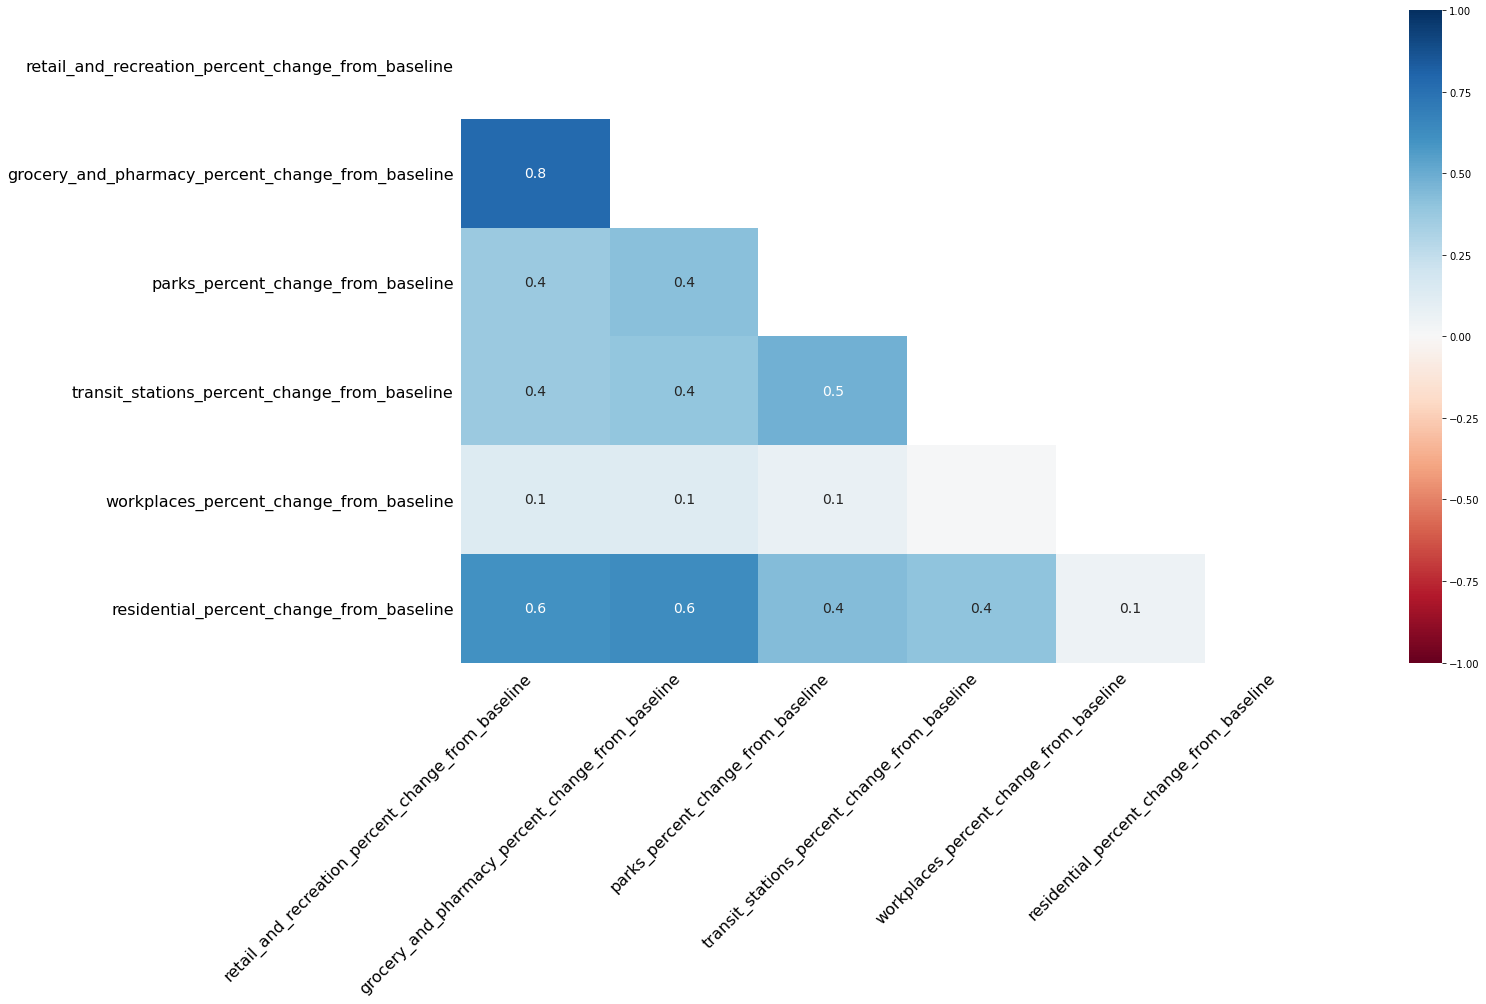

In [ ]:
msno.heatmap(region_df)

Here, we inner join the **cases_by_county** DataFrame wth the **region_df** DataFrame. date, county, state are used as joining columns. This results in a merged dataset containing cases, daeaths and mobility metrics by county and state.

In [ ]:
region_df

,state,county,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Alabama,Autauga,2020-03-01,15.0,13.0,NaN,NaN,3.0,NaN
1,Alabama,Autauga,2020-03-02,15.0,4.0,NaN,NaN,5.0,-1.0
2,Alabama,Autauga,2020-03-03,22.0,8.0,NaN,NaN,4.0,-1.0
3,Alabama,Autauga,2020-03-04,5.0,-4.0,NaN,NaN,3.0,2.0
4,Alabama,Autauga,2020-03-05,7.0,12.0,NaN,NaN,3.0,1.0
...,...,...,...,...,...,...,...,...,...
758285,Wyoming,Sweetwater,2021-01-01,-42.0,NaN,NaN,12.0,-66.0,22.0
758286,Wyoming,Teton,2021-01-01,-46.0,-38.0,13.0,-37.0,-53.0,NaN
758287,Wyoming,Uinta,2021-01-01,-28.0,NaN,NaN,22.0,-63.0,19.0
758288,Wyoming,Washakie,2021-01-01,NaN,NaN,NaN,NaN,-68.0,NaN


In [ ]:
mobility_with_cases = pd.merge(cases_by_county,region_df,left_on=["date","county","state"],right_on=["date","county","state"])
mobility_with_cases = mobility_with_cases.drop(columns="fips")
mobility_with_cases

,date,county,state,cases,deaths,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-03-01,Maricopa,Arizona,1,0.0,11.0,6.0,28.0,7.0,3.0,-2.0
1,2020-03-01,Alameda,California,1,0.0,6.0,9.0,15.0,1.0,4.0,0.0
2,2020-03-01,Humboldt,California,1,0.0,15.0,8.0,24.0,-17.0,2.0,0.0
3,2020-03-01,Marin,California,1,0.0,6.0,-2.0,-2.0,-1.0,2.0,0.0
4,2020-03-01,Napa,California,1,0.0,12.0,7.0,10.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
635206,2021-01-01,Sweetwater,Wyoming,2966,16.0,-42.0,NaN,NaN,12.0,-66.0,22.0
635207,2021-01-01,Teton,Wyoming,2138,4.0,-46.0,-38.0,13.0,-37.0,-53.0,NaN
635208,2021-01-01,Uinta,Wyoming,1558,7.0,-28.0,NaN,NaN,22.0,-63.0,19.0
635209,2021-01-01,Washakie,Wyoming,780,19.0,NaN,NaN,NaN,NaN,-68.0,NaN


By nature, our dataset is fundamentally time-series indexed. If the effect of time on our outcome variable is random, i.e time has a random effect on the number of cases, we can hypothetically treat the data as normal and perform regression. However, we logically believe that the number of cases in a county is in fact correlated with time - as the disease spread/gains momentum mroe cases will arise. This implies that the fundamental assumption of uncorrelated residuals is violated, disallowing us from effectively using GLMs. If it is the case that the data contains autocorrelation, we can account for the trends in time by aggregating the dataset over time for each county - estimating a total sum of cases over a given time period rather than the number of cases on the t+1th day or week. As ARIMA, Prophet and other time-series based methods were not discussed in lecture we opted to remove autocorrelation trends instead, allowing us to use GLMs and nonparametric methods.

To investigate whether or not our data contains autocorrelation, we utilise durbin-watson tests. More information regarding durbin watson tests can be found below.

A Durbin-Watson value between 1.5 and 2.5 implies little to no autocorrelation, while (0,1.5) and (2.5, 4) implies strong autocorrelation positively and negatively, respectively. 

In [ ]:
df = mobility_with_cases.sort_values(by = ['state', 'county', 'date'])
df.head(1)

,date,county,state,cases,deaths,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
7932,2020-03-24,Autauga,Alabama,1,0.0,-20.0,3.0,NaN,NaN,-34.0,13.0


Below, we see that the un-aggregated dataframe is contains highly positive serial autocorrelation. After aggregating by county over time, we see that these trends are largely removed.
- **Durbin-Watson of unaggregated : 0.04**
- **Durbin-Watson of unaggregated : 1.97**

In [ ]:
## Sorted by state, county, date there is strong evidence of autocorrelation
import statsmodels
from statsmodels.formula.api import ols

#fit multiple linear regression model
model = ols('cases ~ retail_and_recreation_percent_change_from_baseline + grocery_and_pharmacy_percent_change_from_baseline + parks_percent_change_from_baseline + transit_stations_percent_change_from_baseline + workplaces_percent_change_from_baseline + residential_percent_change_from_baseline', data=df).fit()

#view model summary
print(model.summary())
from statsmodels.stats.stattools import durbin_watson

#perform Durbin-Watson test
durbin_watson(model.resid)

                            OLS Regression Results                            
Dep. Variable:                  cases   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     1497.
Date:                Mon, 10 May 2021   Prob (F-statistic):               0.00
Time:                        23:30:38   Log-Likelihood:            -1.2184e+06
No. Observations:              109023   AIC:                         2.437e+06
Df Residuals:                  109016   BIC:                         2.437e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

0.05019763070585308

In [ ]:
## Aggregate data by county and time in order to remove autocorrelations
#fit multiple linear regression model
model = ols('cases ~ retail_and_recreation_percent_change_from_baseline + grocery_and_pharmacy_percent_change_from_baseline + parks_percent_change_from_baseline + transit_stations_percent_change_from_baseline + workplaces_percent_change_from_baseline + residential_percent_change_from_baseline', data=df.groupby(['state', 'county']).agg(sum)).fit()

#view model summary
print(model.summary())
from statsmodels.stats.stattools import durbin_watson

#perform Durbin-Watson test
durbin_watson(model.resid)

                            OLS Regression Results                            
Dep. Variable:                  cases   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     199.2
Date:                Mon, 10 May 2021   Prob (F-statistic):          3.24e-209
Time:                        23:30:39   Log-Likelihood:                -40392.
No. Observations:                2595   AIC:                         8.080e+04
Df Residuals:                    2588   BIC:                         8.084e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

1.984672897562813

In the following cells, we identify counties with relatively many nan values for the mobility metrics. We decided to keep all counties that have 20% or fewer nan values (s>=900). Following the identification of said counties, we filter the DataFrame to retain them.

In [ ]:
mobility_with_cases

,date,county,state,cases,deaths,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-03-01,Maricopa,Arizona,1,0.0,11.0,6.0,28.0,7.0,3.0,-2.0
1,2020-03-01,Alameda,California,1,0.0,6.0,9.0,15.0,1.0,4.0,0.0
2,2020-03-01,Humboldt,California,1,0.0,15.0,8.0,24.0,-17.0,2.0,0.0
3,2020-03-01,Marin,California,1,0.0,6.0,-2.0,-2.0,-1.0,2.0,0.0
4,2020-03-01,Napa,California,1,0.0,12.0,7.0,10.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
635206,2021-01-01,Sweetwater,Wyoming,2966,16.0,-42.0,NaN,NaN,12.0,-66.0,22.0
635207,2021-01-01,Teton,Wyoming,2138,4.0,-46.0,-38.0,13.0,-37.0,-53.0,NaN
635208,2021-01-01,Uinta,Wyoming,1558,7.0,-28.0,NaN,NaN,22.0,-63.0,19.0
635209,2021-01-01,Washakie,Wyoming,780,19.0,NaN,NaN,NaN,NaN,-68.0,NaN


In [ ]:
agg = mobility_with_cases.groupby(["state", 'county']).count()
agg

date  cases  deaths  \
state   county                            
Alabama Autauga      278    278     278   
        Baldwin      294    294     294   
        Barbour      249    249     249   
        Bibb         253    253     253   
        Blount       277    277     277   
...                  ...    ...     ...   
Wyoming Sweetwater   278    278     278   
        Teton        265    265     265   
        Uinta        250    250     250   
        Washakie     184    184     184   
        Weston       138    138     138   

                    retail_and_recreation_percent_change_from_baseline  \
state   county                                                           
Alabama Autauga                                                   259    
        Baldwin                                                   294    
        Barbour                                                   181    
        Bibb                                                        7    
        Blount                                                    236    
...                                                               ...    
Wyoming Sweetwater                                                259    
        Teton                                                     241    
        Uinta                                                     157    
        Washakie                                                    8    
        Weston                                                      0    

                    grocery_and_pharmacy_percent_change_from_baseline  \
state   county                                                          
Alabama Autauga                                                   259   
        Baldwin                                                   294   
        Barbour                                                    33   
        Bibb                                                       57   
        Blount                                                    224   
...                                                               ...   
Wyoming Sweetwater                                                 47   
        Teton                                                      37   
        Uinta                                                       4   
        Washakie                                                    2   
        Weston                                                      0   

                    parks_percent_change_from_baseline  \
state   county                                           
Alabama Autauga                                      8   
        Baldwin                                    269   
        Barbour                                      0   
        Bibb                                         0   
        Blount                                       0   
...                                                ...   
Wyoming Sweetwater                                   0   
        Teton                                      154   
        Uinta                                        0   
        Washakie                                     0   
        Weston                                       0   

                    transit_stations_percent_change_from_baseline  \
state   county                                                      
Alabama Autauga                                                 0   
        Baldwin                                               269   
        Barbour                                                 0   
        Bibb                                                    0   
        Blount                                                  0   
...                                                           ...   
Wyoming Sweetwater                                            259   
        Teton                                                 238   
        Uinta                                                 250   
        Washakie                 

In [ ]:


agg = mobility_with_cases.groupby(["state", 'county']).count()
s = agg.sum(axis =1)
counties_no_missing = s[s >= 1700].index.values.tolist()
counties_no_missing
s

state    county    
Alabama  Autauga       1868
         Baldwin       2596
         Barbour       1226
         Bibb          1086
         Blount        1797
                       ... 
Wyoming  Sweetwater    1892
         Teton         1730
         Uinta         1484
         Washakie       744
         Weston         552
Length: 2595, dtype: int64

In [ ]:
mobility_with_cases = mobility_with_cases.set_index(['state','county'],)
df = mobility_with_cases[mobility_with_cases.index.isin(counties_no_missing)]
df = df.reset_index()
df


,state,county,date,cases,deaths,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Arizona,Maricopa,2020-03-01,1,0.0,11.0,6.0,28.0,7.0,3.0,-2.0
1,California,Alameda,2020-03-01,1,0.0,6.0,9.0,15.0,1.0,4.0,0.0
2,California,Humboldt,2020-03-01,1,0.0,15.0,8.0,24.0,-17.0,2.0,0.0
3,California,Marin,2020-03-01,1,0.0,6.0,-2.0,-2.0,-1.0,2.0,0.0
4,California,Napa,2020-03-01,1,0.0,12.0,7.0,10.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
335212,Wyoming,Fremont,2021-01-01,3968,64.0,-45.0,-33.0,NaN,NaN,-67.0,22.0
335213,Wyoming,Laramie,2021-01-01,7045,62.0,-36.0,-32.0,-11.0,-25.0,-74.0,24.0
335214,Wyoming,Natrona,2021-01-01,6479,92.0,-38.0,-38.0,-16.0,-46.0,-72.0,24.0
335215,Wyoming,Sweetwater,2021-01-01,2966,16.0,-42.0,NaN,NaN,12.0,-66.0,22.0


We visualise the nan-values post-filtering for counties that contain 20% or fewer nan values. As we can see there are still many counties that have missing or nan values for various mobility metrics.

<AxesSubplot:>

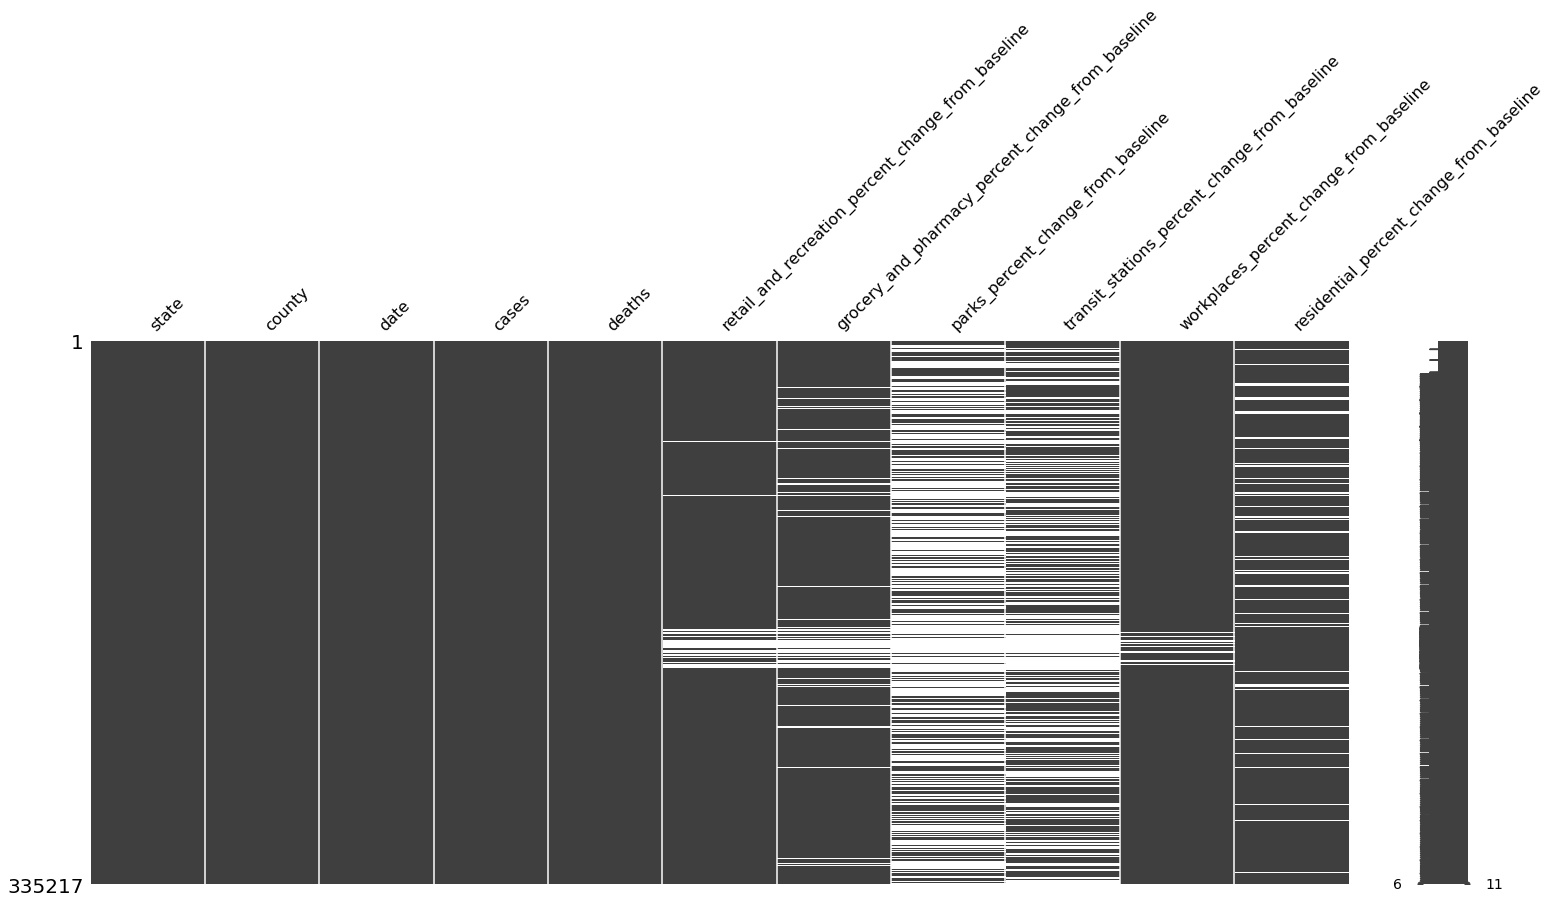

In [ ]:
msno.matrix(df)

We made the decision to forward fill mobility metrics under the assumption that nan-valued gaps implied a lack of change as the columns are all labeled "change from baseline). For every state, county we find the last true value and fill nan forward with that value until another true value is found. If nan values persist post-imputation it suggests that there are state, county combinations that entirely consist of nan values. The visualisation below confirms this suspicion. 

This leaves us with two option: 
- Retain state, county combinations that have complete records for every variable/ mobility metric
    - Results in a dataset of size (286, 9)
- Remove the two variables/ mobility metrics that appear to have the most missing/nan values (parks_percent_change, transit_stations_percent_change)
    - Results in a dataset of size (822, 7)

We decided to remove the two variables containing mostly nan values in order to acheive a larger dataset. We felt it was better to have a larger dataset with 2 fewer explanatory variables than a tiny dataset with more explanatory variables.

In [ ]:
## forward fill values for mobility metrics based on state county. This forward fills mobilit metric values for a given state,county based on last recorded value.

df.update(df.sort_values(["state", "county"]).groupby(['state', 'county']).ffill())

# msno.matrix(df)

<AxesSubplot:>

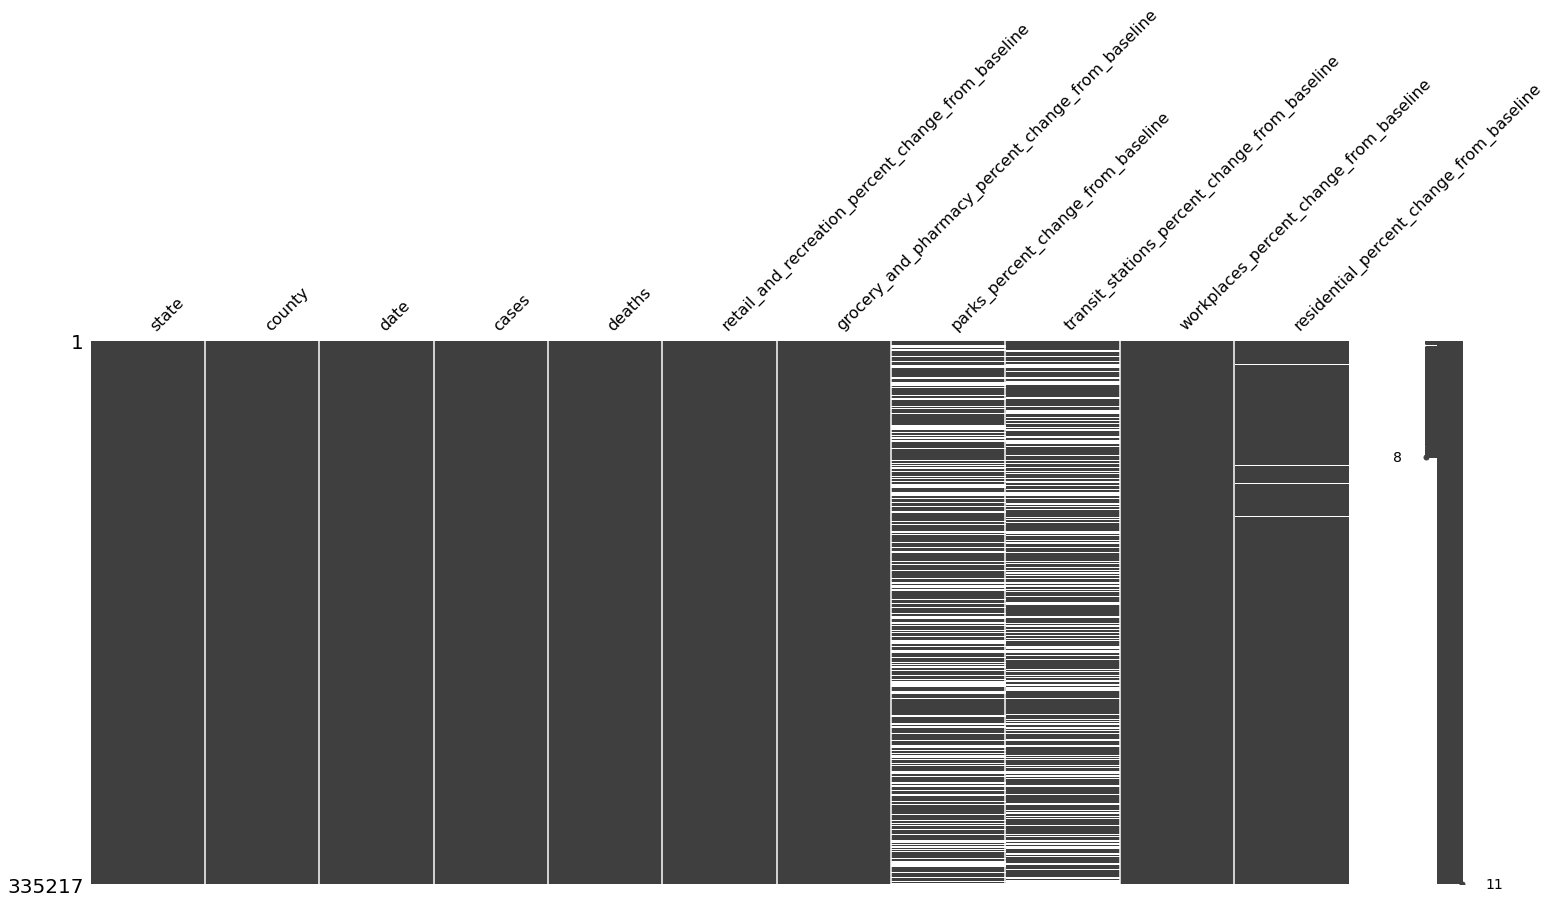

In [ ]:
msno.matrix(df)

In [ ]:
df

,state,county,date,cases,deaths,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Arizona,Maricopa,2020-03-01,1,0.0,11.0,6.0,28.0,7.0,3.0,-2.0
1,California,Alameda,2020-03-01,1,0.0,6.0,9.0,15.0,1.0,4.0,0.0
2,California,Humboldt,2020-03-01,1,0.0,15.0,8.0,24.0,-17.0,2.0,0.0
3,California,Marin,2020-03-01,1,0.0,6.0,-2.0,-2.0,-1.0,2.0,0.0
4,California,Napa,2020-03-01,1,0.0,12.0,7.0,10.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
335212,Wyoming,Fremont,2021-01-01,3968,64.0,-45.0,-33.0,NaN,NaN,-67.0,22.0
335213,Wyoming,Laramie,2021-01-01,7045,62.0,-36.0,-32.0,-11.0,-25.0,-74.0,24.0
335214,Wyoming,Natrona,2021-01-01,6479,92.0,-38.0,-38.0,-16.0,-46.0,-72.0,24.0
335215,Wyoming,Sweetwater,2021-01-01,2966,16.0,-42.0,10.0,NaN,12.0,-66.0,22.0


In [ ]:
## Drop columns that are containing many nan values - this was done to keep a larger dataset. 
## We could either keep counties that have all 6 mobility metrics fully recorded (no nan) giving us a data set of length 286, or drop two mobility measures and have a dataset of length 822
df = df.drop(columns = ['parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline'])
df

,state,county,date,cases,deaths,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Arizona,Maricopa,2020-03-01,1,0.0,11.0,6.0,3.0,-2.0
1,California,Alameda,2020-03-01,1,0.0,6.0,9.0,4.0,0.0
2,California,Humboldt,2020-03-01,1,0.0,15.0,8.0,2.0,0.0
3,California,Marin,2020-03-01,1,0.0,6.0,-2.0,2.0,0.0
4,California,Napa,2020-03-01,1,0.0,12.0,7.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
335212,Wyoming,Fremont,2021-01-01,3968,64.0,-45.0,-33.0,-67.0,22.0
335213,Wyoming,Laramie,2021-01-01,7045,62.0,-36.0,-32.0,-74.0,24.0
335214,Wyoming,Natrona,2021-01-01,6479,92.0,-38.0,-38.0,-72.0,24.0
335215,Wyoming,Sweetwater,2021-01-01,2966,16.0,-42.0,10.0,-66.0,22.0


<AxesSubplot:>

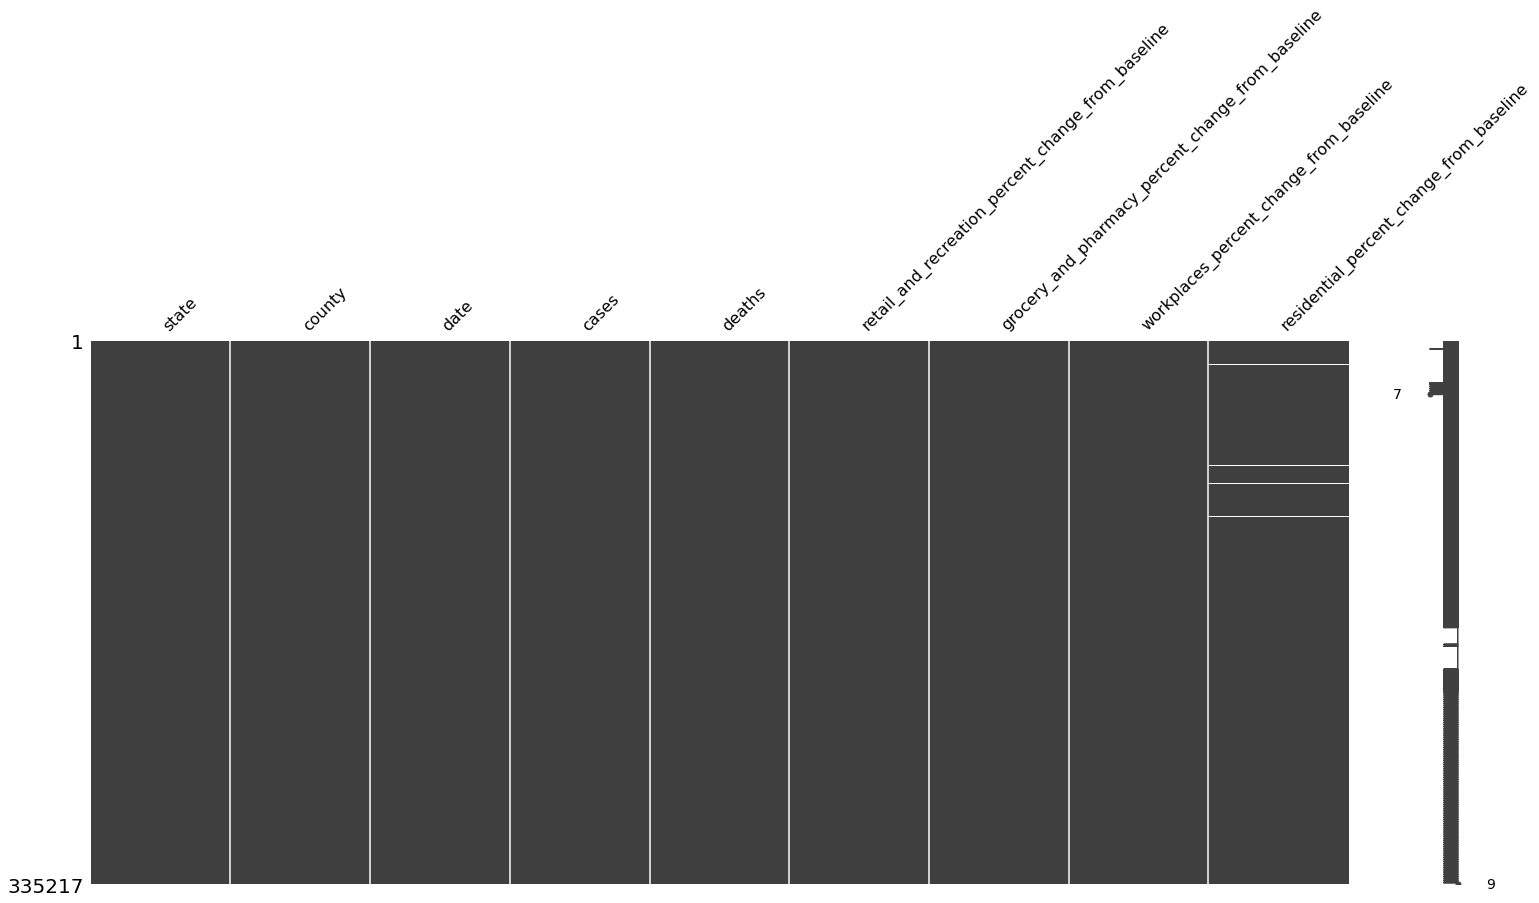

In [ ]:
msno.matrix(df)

We select the counties that only contain complete records post-imputation

In [ ]:
df

,state,county,date,cases,deaths,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Arizona,Maricopa,2020-03-01,1,0.0,11.0,6.0,3.0,-2.0
1,California,Alameda,2020-03-01,1,0.0,6.0,9.0,4.0,0.0
2,California,Humboldt,2020-03-01,1,0.0,15.0,8.0,2.0,0.0
3,California,Marin,2020-03-01,1,0.0,6.0,-2.0,2.0,0.0
4,California,Napa,2020-03-01,1,0.0,12.0,7.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
335212,Wyoming,Fremont,2021-01-01,3968,64.0,-45.0,-33.0,-67.0,22.0
335213,Wyoming,Laramie,2021-01-01,7045,62.0,-36.0,-32.0,-74.0,24.0
335214,Wyoming,Natrona,2021-01-01,6479,92.0,-38.0,-38.0,-72.0,24.0
335215,Wyoming,Sweetwater,2021-01-01,2966,16.0,-42.0,10.0,-66.0,22.0


In [ ]:
agg = df.groupby(["state", 'county']).count()
s = agg.sum(axis =1)
max(s)

4158

In [ ]:
agg = df.groupby(["state", 'county']).count()
s = agg.sum(axis =1)
counties_no_missing = s[(s >=1900) & (s <= 2300)].index.values.tolist()
len(counties_no_missing)
df = df.set_index(['state','county'])
df = df[df.index.isin(counties_no_missing)]
final_df = df.groupby(["state", 'county']).agg(np.mean)
final_df

cases     deaths  \
state   county                               
Alabama Autauga     1318.082734  20.118705   
        Baldwin     3882.074830  42.908163   
        Blount      1251.574007  13.945848   
        Calhoun     2587.831034  38.017241   
        Chambers     929.685512  34.151943   
...                         ...        ...   
Wyoming Campbell     768.868794   3.758865   
        Fremont      998.664360  14.602076   
        Laramie     1387.371134   8.271478   
        Natrona     1224.427083  11.885417   
        Sweetwater   547.942446   2.776978   

                    retail_and_recreation_percent_change_from_baseline  \
state   county                                                           
Alabama Autauga                                             -7.053957    
        Baldwin                                             -7.217687    
        Blount                                              -4.837545    
        Calhoun                                            -10.320690    
        Chambers                                            -5.971731    
...                                                               ...    
Wyoming Campbell                                           -11.180851    
        Fremont                                              2.093426    
        Laramie                                            -13.869416    
        Natrona                                            -10.753472    
        Sweetwater                                          -6.672662    

                    grocery_and_pharmacy_percent_change_from_baseline  \
state   county                                                          
Alabama Autauga                                              4.992806   
        Baldwin                                              8.231293   
        Blount                                               5.133574   
        Calhoun                                             -6.437931   
        Chambers                                             2.724382   
...                                                               ...   
Wyoming Campbell                                            -4.464539   
        Fremont                                              7.629758   
        Laramie                                              3.374570   
        Natrona                                              4.684028   
        Sweetwater                                           8.665468   

                    workplaces_percent_change_from_baseline  \
state   county                                                
Alabama Autauga                                  -25.964029   
        Baldwin                                  -25.374150   
        Blount                                   -26.924188   
        Calhoun                                  -25.379310   
        Chambers                                 -24.628975   
...                                                     ...   
Wyoming Campbell                                 -21.624113   
        Fremont                                  -22.141869   
        Laramie                                  -26.044674   
        Natrona                                  -25.305556   
        Sweetwater                               -21.604317   

                    residential_percent_change_from_baseline  
state   county                                                
Alabama Autauga                                     8.456835  
        Baldwin                                     4.812925  
        Blount                                      7.898917  
        Calhoun                                     5.982759  
        Chambers                                    8.607774  
...                                                      ...  
Wyoming Campbell                                    6.446809  
        Fremont                                     5.726644  
        Laramie                                     7.343643  
 

Here, we peform the final join, adding the population of each column to our aggregated dataset.

In [ ]:
final_df = pd.merge(final_df,countypop_2019,how = 'inner',left_index=True,right_on=["state","county"])
final_df


,cases,deaths,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,state,county,population
1,1318.082734,20.118705,-7.053957,4.992806,-25.964029,8.456835,Alabama,Autauga,55869
2,3882.074830,42.908163,-7.217687,8.231293,-25.374150,4.812925,Alabama,Baldwin,223234
5,1251.574007,13.945848,-4.837545,5.133574,-26.924188,7.898917,Alabama,Blount,57826
8,2587.831034,38.017241,-10.320690,-6.437931,-25.379310,5.982759,Alabama,Calhoun,113605
9,929.685512,34.151943,-5.971731,2.724382,-24.628975,8.607774,Alabama,Chambers,33254
...,...,...,...,...,...,...,...,...,...
3172,768.868794,3.758865,-11.180851,-4.464539,-21.624113,6.446809,Wyoming,Campbell,46341
3176,998.664360,14.602076,2.093426,7.629758,-22.141869,5.726644,Wyoming,Fremont,39261
3180,1387.371134,8.271478,-13.869416,3.374570,-26.044674,7.343643,Wyoming,Laramie,99500
3182,1224.427083,11.885417,-10.753472,4.684028,-25.305556,5.711806,Wyoming,Natrona,79858


Here we add three columns:
- total cases per capita, the number of cases divided by population
- total deaths per capita, the number of deaths divided by population
- log total cases per capita, the log of the number of cases per capita

In [ ]:
final_df['average_cases_per_capita'] = final_df['cases'] / final_df['population']
final_df['average_deaths_per_capita'] = final_df['deaths'] / final_df['population']
final_df['log_average_cases_per_capita'] = np.log(final_df[ 'average_cases_per_capita'])
final_df

,cases,deaths,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,state,county,population,average_cases_per_capita,average_deaths_per_capita,log_average_cases_per_capita
1,1318.082734,20.118705,-7.053957,4.992806,-25.964029,8.456835,Alabama,Autauga,55869,0.023592,0.000360,-3.746831
2,3882.074830,42.908163,-7.217687,8.231293,-25.374150,4.812925,Alabama,Baldwin,223234,0.017390,0.000192,-4.051851
5,1251.574007,13.945848,-4.837545,5.133574,-26.924188,7.898917,Alabama,Blount,57826,0.021644,0.000241,-3.833037
8,2587.831034,38.017241,-10.320690,-6.437931,-25.379310,5.982759,Alabama,Calhoun,113605,0.022779,0.000335,-3.781907
9,929.685512,34.151943,-5.971731,2.724382,-24.628975,8.607774,Alabama,Chambers,33254,0.027957,0.001027,-3.577084
...,...,...,...,...,...,...,...,...,...,...,...,...
3172,768.868794,3.758865,-11.180851,-4.464539,-21.624113,6.446809,Wyoming,Campbell,46341,0.016592,0.000081,-4.098862
3176,998.664360,14.602076,2.093426,7.629758,-22.141869,5.726644,Wyoming,Fremont,39261,0.025437,0.000372,-3.671568
3180,1387.371134,8.271478,-13.869416,3.374570,-26.044674,7.343643,Wyoming,Laramie,99500,0.013943,0.000083,-4.272747
3182,1224.427083,11.885417,-10.753472,4.684028,-25.305556,5.711806,Wyoming,Natrona,79858,0.015333,0.000149,-4.177777


A correlation matrix to visualise correlations between different variables

<AxesSubplot:>

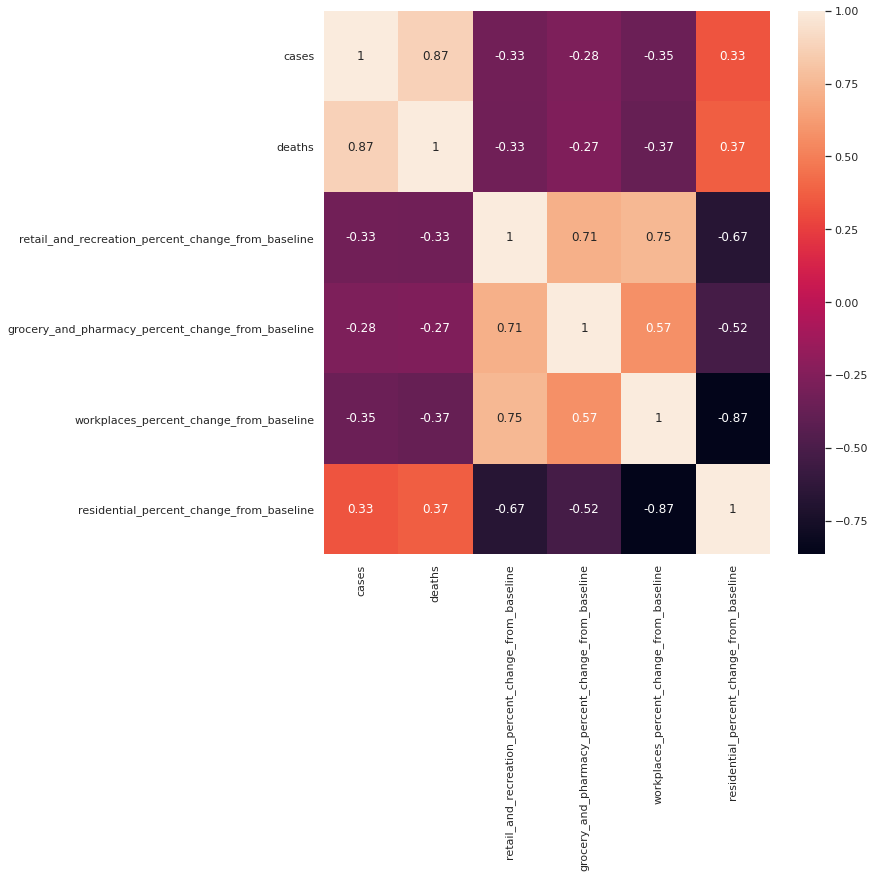

In [ ]:
sns.set(font_scale = 1)
fig, ax = plt.subplots(figsize=(10,10))
grouped_bydate= df.groupby('county').mean().reset_index()
corr_df = grouped_bydate.corr()
sns.heatmap(corr_df, annot=True)

In the following cells, we plot the distributions of various variables, in order to gain clarity and insight into what GLMs and non-parametric methods may or may not work

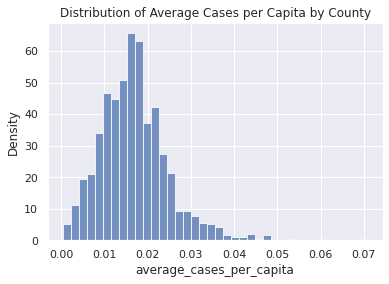

In [ ]:
ax=sns.histplot(final_df, x = 'average_cases_per_capita', stat = 'density')
plt.title('Distribution of Average Cases per Capita by County');

Text(0.5, 1.0, 'Distribution of Cases')

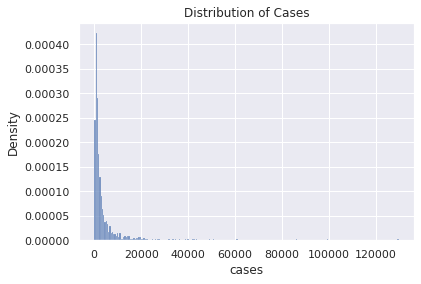

In [ ]:
ax=sns.histplot(final_df, x = 'cases', stat = 'density')
plt.title('Distribution of Cases')


Text(0.5, 1.0, 'Distribution of Average Deaths per Capita by County')

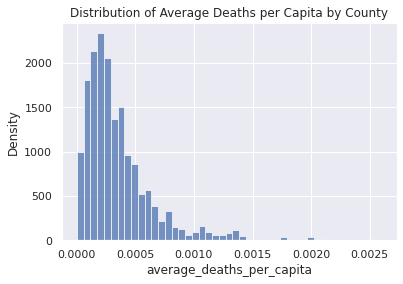

In [ ]:
ax=sns.histplot(final_df, x = 'average_deaths_per_capita', stat = 'density')
plt.title('Distribution of Average Deaths per Capita by County')


Text(0.5, 1.0, 'Distribution of retail_and_recreation_percent_change_from_baseline Metric')

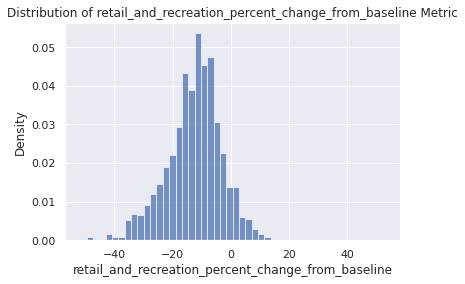

In [ ]:
ax=sns.histplot(final_df, x = 'retail_and_recreation_percent_change_from_baseline', stat = 'density')
plt.title('Distribution of retail_and_recreation_percent_change_from_baseline Metric')


Text(0.5, 1.0, 'Distribution of residential_percent_change_from_baseline Metric')

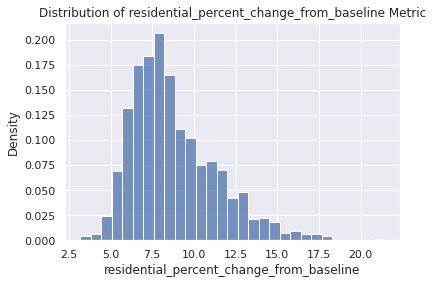

In [ ]:
ax=sns.histplot(final_df, x = 'residential_percent_change_from_baseline', stat = 'density')
plt.title('Distribution of residential_percent_change_from_baseline Metric')


# Model Creation

## Random Forest Regressor

We created a Random Forest Regressor that takes in parameters : population, retail_and_recreation_percent_change_from_baseline, grocery_and_pharmacy_percent_change_from_baseline, 'workplaces_percent_change_from_baseline','residential_percent_change_from_baseline to predict the outcome variable average number of cases. The following cell tests a variety of Random Forest Parameters and picks the ones the optimize accuracy for the given data.

In [ ]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
dbs_df =final_df.copy()
X = dbs_df.loc[: , ['population','retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline','workplaces_percent_change_from_baseline','residential_percent_change_from_baseline']]
y = dbs_df.loc[:, 'average_cases_per_capita']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=0)
kf = KFold(5, shuffle=True, random_state=0)
rf = RandomForestRegressor()
pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor())])
param_grid = {'rf__bootstrap': [True, False],
            'rf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
            'rf__max_features': ['auto', 'sqrt'],
            'rf__min_samples_leaf': [1, 2, 4, 6, 10],
            'rf__min_samples_split': [2, 5, 10],
            'rf__n_estimators': [130, 180, 230, 500]
}
print(rf.get_params().keys())
search = RandomizedSearchCV(pipe, param_grid, cv =kf,n_jobs = -1, scoring = 'neg_mean_squared_error')
best_model = search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
"Test Set MSE: ", metrics.mean_squared_error(best_model.predict(X_test), y_test, squared = False)
    

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
Best parameter (CV score=-0.000):
{'rf__n_estimators': 500, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 10, 'rf__max_features': 'sqrt', 'rf__max_depth': None, 'rf__bootstrap': True}


('Test Set MSE: ', 0.007009038450575305)

In [ ]:
print("Mean:    ", np.mean(final_df['average_cases_per_capita']))
print("Variance:", np.var(final_df['average_cases_per_capita']))

Mean:     0.016845447271611386
Variance: 6.395502512115922e-05


In [ ]:
final_df
estimator = best_model.best_estimator_
estimator

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_features='sqrt', min_samples_leaf=10,
                                       min_samples_split=10,
                                       n_estimators=500))])

## Generalized Linear Model

In the following block, we created a GLM with the same feature matrix as the Random Forest Regressor. We

In [ ]:

# with pm.Model() as gaussian_model:
model = statsmodels.formula.api.glm('average_cases_per_capita~population+retail_and_recreation_percent_change_from_baseline+grocery_and_pharmacy_percent_change_from_baseline+workplaces_percent_change_from_baseline+residential_percent_change_from_baseline',data = final_df, family=sm.families.NegativeBinomial())
# draw posterior samples using NUTS sampling
# negbin_trace = model.sample(1000, cores=2, target_accept=0.95, return_inferencedata=True)
result = model.fit()
print(result.summary())

                    Generalized Linear Model Regression Results                     
Dep. Variable:     average_cases_per_capita   No. Observations:                 1061
Model:                                  GLM   Df Residuals:                     1055
Model Family:              NegativeBinomial   Df Model:                            5
Link Function:                          log   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -90.881
Date:                      Mon, 10 May 2021   Deviance:                       3.5973
Time:                              23:31:05   Pearson chi2:                     3.57
No. Iterations:                           4                                         
Covariance Type:                  nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

## GAUSSIAN MODEL 

In [ ]:
# with pm.Model() as gaussian_model:
model = statsmodels.formula.api.glm('average_cases_per_capita~population+retail_and_recreation_percent_change_from_baseline+grocery_and_pharmacy_percent_change_from_baseline+workplaces_percent_change_from_baseline+residential_percent_change_from_baseline',data = final_df, family=sm.families.Gaussian())
# draw posterior samples using NUTS sampling
# negbin_trace = model.sample(1000, cores=2, target_accept=0.95, return_inferencedata=True)
result = model.fit()
print(result.summary())

                    Generalized Linear Model Regression Results                     
Dep. Variable:     average_cases_per_capita   No. Observations:                 1061
Model:                                  GLM   Df Residuals:                     1055
Model Family:                      Gaussian   Df Model:                            5
Link Function:                     identity   Scale:                      6.0170e-05
Method:                                IRLS   Log-Likelihood:                 3653.1
Date:                      Mon, 10 May 2021   Deviance:                     0.063479
Time:                              23:31:05   Pearson chi2:                   0.0635
No. Iterations:                           3                                         
Covariance Type:                  nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

In [ ]:
# with pm.Model() as gaussian_model:
model = statsmodels.formula.api.glm('average_cases_per_capita~population+retail_and_recreation_percent_change_from_baseline+grocery_and_pharmacy_percent_change_from_baseline+workplaces_percent_change_from_baseline+residential_percent_change_from_baseline',data = final_df, family=sm.families.Gamma())
# draw posterior samples using NUTS sampling
# negbin_trace = model.sample(1000, cores=2, target_accept=0.95, return_inferencedata=True)
result = model.fit()
print(result.summary())

                    Generalized Linear Model Regression Results                     
Dep. Variable:     average_cases_per_capita   No. Observations:                 1061
Model:                                  GLM   Df Residuals:                     1055
Model Family:                         Gamma   Df Model:                            5
Link Function:                inverse_power   Scale:                         0.20033
Method:                                IRLS   Log-Likelihood:                 3694.2
Date:                      Mon, 10 May 2021   Deviance:                       253.86
Time:                              23:31:05   Pearson chi2:                     211.
No. Iterations:                           7                                         
Covariance Type:                  nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

In [ ]:

# generate predictions
ypred = result.predict(X)

# calculate rmse
rmse = rmse(y, ypred)

In [ ]:
rmse

0.007695885556974207

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=85f80cd7-7338-4240-8241-ac330a282ab5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>